# Тема 2.3. Семантический нейросетевой анализ текста

**2.3.1. Векторное представление единиц текста.**  
2.3.2. Обучение нейросетевой модели word2vec.  
2.3.3. Нейросетевая модель torch.embedding.  
2.3.4. Анализ тематик электронных писем.  
2.3.5. Анализ семантической близости двух текстов.  


In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Задача - представить текст в виде числового вектора. В виде, пригодном для дальнейшей обработки алгоритмами МО.  
Кроме этого хотелось бы учесть семантику (смысл) текста/предложения/слова.  

## One Hot Encoding (Label binarizer)  
  
Задача - кодировать слово в вектор.  
Самый простой способ - бинарное кодирование.  
Число слов в корпусе равно $K$  
Сопоставим слову с номером $j$ вектор длины $K$, все значения которого равны нулю, за исключением $K_{i}$, которое равно 1.  
В таблице представлен пример для словаря из 3 слов.

|          |  |  |  |
|----------|:-:|:-:|--:|
| белеет   | 1 | 0 | 0 |
| парус    | 0 | 1 | 0 |
| одинокий | 0 | 0 | 1 |
  
Просто, быстро, легко объяснить, подходит для простых задач. Активно применяется для кодирования категориальных переменных.  
  
Недостатки:
 - Теряется смысл слов. Чаще всего слова (единицы в векторе) сортируются в произвольном порядке (по алфавиту, по очереди следования в корпусе - этот порядок не имеет никакого отношения к смыслу слов ).  
 - Размер вектора $K$ растет с ростом словаря.  
 - Слова, отсутствующие в словаре (out of vocabulary - OOV) игнорируются.  
 - Модель жестко привязана к обучающей выборке (словам в выборке). Переиспользование модели на других задачах сложно, или даже невозможно.  



Рассмотрим пример OneHot-кодирования с применением библиотеки `scikit-learn`.  

In [39]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
words = ['белеет', 'парус', 'одинокий']
binarizer.fit(words)

for w in words:
    print(w, binarizer.transform([w]))

# OOV
oov_w = 'ничоси'
print(oov_w, binarizer.transform([oov_w]))

белеет [[1 0 0]]
парус [[0 0 1]]
одинокий [[0 1 0]]
ничоси [[0 0 0]]


Представление текста - функция от векторов слов.

In [41]:
doc_tokens = words + [oov_w]
v = binarizer.transform(doc_tokens).any(axis=1) * 1
print(' '.join(doc_tokens), v)

белеет парус одинокий ничоси [1 1 1 0]


## Count vectorizer  

Задача - кодировать текст документа в вектор.  
Число слов в корпусе равно $K$  
Сопоставим документу с номером $j$ вектор длины $K$. Значение $K_{i}$ соответствует количеству (абсолютной частоте) встречаемости слова $i$ в тексте $j$.  
Смысл документа представлен частотой слов этого документа.  
  
Недостатки:
Недостатки:
 - OOV слова игнорируются.  
 - Размер вектора $K$ растет с ростом словаря.  

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

corpora = [
    "Зайчик ножкой дрыгает.",
    "Зайчик скачет и ножкой дрыгает. Дрыгает и скачет.",
]

# Параметры по умолчанию разбивают текст на токены длиной не менее 2 символов.
# в примере ниже `и` будет проигнорирован.
count_vectorizer = CountVectorizer()
count_vectorizer.fit(corpora)

print('Словарь:', count_vectorizer.get_feature_names_out())

for doc in corpora:
    print(doc, count_vectorizer.transform([doc]).toarray())

oov_text = "Отсель грозить мы будем шведу."
print('OOV!', oov_text, count_vectorizer.transform([oov_text]).toarray())

Словарь: ['дрыгает' 'зайчик' 'ножкой' 'скачет']
Зайчик ножкой дрыгает. [[1 1 1 0]]
Зайчик скачет и ножкой дрыгает. Дрыгает и скачет. [[2 1 1 2]]
OOV! Отсель грозить мы будем шведу. [[0 0 0 0]]


## Способы уменьшения словаря.  
  
В рассмотренных выше подходах размер выходного вектора увеличивается с ростом словаря. Как можно решить этот вопрос?  

### Снижение размерности
Для уменьшения размерности вектора могут быть применены методы снижения размерности, например метод главных компонент (PCA), t-SNE. Примеры использования приведены в других темах курса.  

### N-граммы.  
Слово может иметь несколько форм (склонение, число, род). Например слово *ёж* может быть изменено на *ежей*, *ежами*, *ежихой*...  
Популярные методы представления однокоренных слов:  
 - **лемматизация** - приведения слова в начальную форму. Например *ежей -> ёж* (мужской род, именительный падеж, единственное число).  
 - **стемминг** - удаление аффиксов (начало и окончание, приставка и суффикс). Для этого проводится частотный анализ словарей, выделяются частые "хвосты" и удаляются. Например *ей* - частое окончание, значит *ежей -> еж*.  
  
Перечисленные методы активно применяются в задачах NLP, но не будут рассмотрены в данном курсе.  

N-грамма (N-gramm) - последовательность символов длиной $N$. 1-грамма (униграмма), 2-грамма (биграмма), 3-, 4-, 5-граммы и так далее.  
Такой подход позволяет учитывать однокоренные слова (содержат одинаковые подстроки). Несловарные слова (OOV) будут комбинациями известных Н-грамм.  
Количество Н-грамм, полученных из всех слов языка меньше количества их комбинаций (слов).  
Для разных задач могут использоваться как побуквенные Н-граммы, так и Н-граммы по словам. Применение Н-грамм будет рассмотрено подробнее в следующих темах.  

  
### Хэширование.  
Мы можем применить функцию хэширования, котрая преобразует все наши слова в один из Н "символов" и таким способом уменьшить размерность выходного вектора. Можно использовать реализацию `sklearn.feature_extraction.text.HashingVectorizer`.

### Исключение незначиных слов (стоп-слов).  
Стоп-слово - это слово, которое одинаково часто встречается во всех документах, то есть не является важным в контексте документа.  
Для уменьшения количества словаря и исключения "лишней" информации, мы можем использовать специальные словари стоп-слов (предлоги, частицы, цифры и прочее).  

In [63]:
from nltk.corpus import stopwords as nltk_stopwords
from string import punctuation

print('Stopwords:')
print(', '.join(sorted(nltk_stopwords.words('russian'))))

print('Punctuation:')
print(', '.join(punctuation))

Stopwords:
а, без, более, больше, будет, будто, бы, был, была, были, было, быть, в, вам, вас, вдруг, ведь, во, вот, впрочем, все, всегда, всего, всех, всю, вы, где, да, даже, два, для, до, другой, его, ее, ей, ему, если, есть, еще, ж, же, за, зачем, здесь, и, из, или, им, иногда, их, к, как, какая, какой, когда, конечно, кто, куда, ли, лучше, между, меня, мне, много, может, можно, мой, моя, мы, на, над, надо, наконец, нас, не, него, нее, ней, нельзя, нет, ни, нибудь, никогда, ним, них, ничего, но, ну, о, об, один, он, она, они, опять, от, перед, по, под, после, потом, потому, почти, при, про, раз, разве, с, сам, свою, себе, себя, сейчас, со, совсем, так, такой, там, тебя, тем, теперь, то, тогда, того, тоже, только, том, тот, три, тут, ты, у, уж, уже, хорошо, хоть, чего, чем, через, что, чтоб, чтобы, чуть, эти, этого, этой, этом, этот, эту, я
Punctuation:
!, ", #, $, %, &, ', (, ), *, +, ,, -, ., /, :, ;, <, =, >, ?, @, [, \, ], ^, _, `, {, |, }, ~


#### Term Frequency - Inverse document frequency (TFIdf).  
  
Или использовать частотный анализ.  
Один из методов уменьшения частоты не значимых слов является TFIdf.
  
$tf-idf(t, d, D) = tf(t,d) \times idf(t, D)$  
  
где:  
$tf(t, d) = \frac{n_t} {\sum_k n_k}$  - частота термина  
  
$n_t$ - число вхождений слова t в документе  
$\sum_k n_k$ - число слов в документе  
  
$idf(t,D)=log \frac {|D|} {|\{d_i \in D | t \in d_i \}|}$ - инвертированная частота документа
  
$|D|$  - количество документов  
$|\{d_i \in D | t \in d_i \}|$ - количество документов D в которых встречается слово $t$  
  

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpora = [
    "Зайчик ножкой дрыгает.",
    "Зайчик скачет и ножкой дрыгает. Дрыгает и скачет.",
]

tfidf = TfidfVectorizer()
tfidf.fit(corpora)

print('Словарь:', tfidf.get_feature_names_out())

for doc in corpora:
    print(doc, tfidf.transform([doc]).toarray())

oov_text = "Отсель грозить мы будем шведу."
print('OOV!', oov_text, tfidf.transform([oov_text]).toarray())


Словарь: ['дрыгает' 'зайчик' 'ножкой' 'скачет']
Зайчик ножкой дрыгает. [[0.57735027 0.57735027 0.57735027 0.        ]]
Зайчик скачет и ножкой дрыгает. Дрыгает и скачет. [[0.53641614 0.26820807 0.26820807 0.75391417]]
OOV! Отсель грозить мы будем шведу. [[0. 0. 0. 0.]]


## Семантическое пространство.  
  
[Семантика](https://ru.wikipedia.org/wiki/Семантика) — смысл (значение) текста или отдельного слова. Раздел лингвистики, изучающий смысловое значение единиц языка.  
[Семантический анализ](https://ru.wikipedia.org/wiki/Семантический_анализ) — одно из направлений автоматической обработки текста, заключается в выделении семантических отношений, формировании семантического представления текстов.  

Документы (целые тексты, отдельные предложения) и слова могут быть определенным образом расположены в векторном пространстве так, чтобы, например близкие по смыслу слова были "близки", разные - "удалены".  
Имея эффективный способ представления слов/документов в векторном (семантическом) пространстве, мы можем решать различные бизнес-задачи, например установление степени близости, классификацию, кластеризацию.  

Пример.
Для простоты возьмём 2 простых текста на 2 разные темы. Тексты содержат 3 уникальных слова ($K=3$, для удобства видуализации на 3d-графике):  
- [токены](https://en.wikipedia.org/wiki/Token) текста
- токены криптовалюты



Стеммы:
займемся разделением текста на токены : займ разделен текст ток
токенизация - разделение текста на токены : токенизац разделен текст ток
токен - это единица учета криптовалюты : ток эт единиц учет криптовалют
x_vect.shape: (3, 9)
x_reduced.shape: (3, 2)


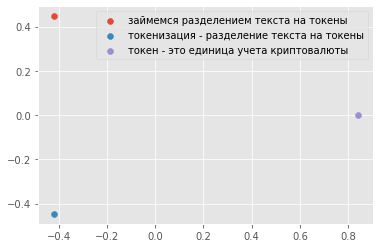

Евклидово расстояние:
займемся разделением текста на токены , займемся разделением текста на токены : 0.00
займемся разделением текста на токены , токенизация - разделение текста на токены : 0.89
займемся разделением текста на токены , токен - это единица учета криптовалюты : 1.34


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics.pairwise import euclidean_distances
from string import punctuation

STOPWORDS = list(nltk_stopwords.words('russian')) + list(punctuation)

docs = np.array([
    'займемся разделением текста на токены',
    'токенизация - разделение текста на токены',
    'токен - это единица учета криптовалюты',
])

tokenizer = WhitespaceTokenizer()
stemmer = SnowballStemmer('russian')

def preprocess_text(text: str) -> str:
    """
    Предвариательная обработка текста.

    Текст приводится к нижнему регистру, удаляются стоп-слова, токены заменяются на стеммы.

    Args:
        text (str): Исходный текст.
    Returns:
        str: Обработанный текст.
    """

    tokens = [t.lower() for t in tokenizer.tokenize(text) if t not in STOPWORDS]
    return ' '.join([stemmer.stem(t) for t in tokens])


x = [preprocess_text(t) for t in docs]
print('Стеммы:', *[f'{docs[i]} : {x[i]}' for i in range(len(x))], sep='\n')

x_vect = TfidfVectorizer().fit_transform(x).toarray()
x_reduced = PCA(n_components=2).fit_transform(x_vect)
print('x_vect.shape:', x_vect.shape)
print('x_reduced.shape:', x_reduced.shape)

# График
fig, ax = plt.subplots()
for coords, label in zip(x_reduced, docs):
    ax.scatter(coords[0], coords[1], label=label)

ax.legend()
ax.grid(True)
plt.show()

# Посчитаем меру близости текстов.
print('Евклидово расстояние:')
for i1, i2 in ((0,0), (0,1), (0,2)):
    d = euclidean_distances([x_vect[i1]], [x_vect[i2]])[0][0]
    print(docs[i1], ',', docs[i2], ':', f'{d:2.2f}')


# Выводы

- Векторизация - это приведения текста в вид, пригодный для задач машинного обучения. Множество векторов текстов в Н-мерном пространстве называют семантическим пространством.  
- Простые методы часто применяют для простых задач, но они всё еще не позволяют учитывать семантику текста.  
- Перечисленные методы выдают вектор текста размерностью Н, где Н зависит от количества слов в документах.  
- Описанные простые методы жестко привязаны к данным, на которых они обучались. Переиспользование модели в других задачах, на других текстах затруднительно.  
- Уменьшать размерность вектора  можно приведением слова к нормальной форме или стемме, исключением стоп-слов (как по словарю, так и с помощью частотного анализа), так и разбивая слова на Н-граммы (количество Н-грамм всех слов языка меньше чем количество их комбинаций).  
- Уменьшить размерность вектора можно методами снижения размерности (например PCA, t-SNE).  

# Дополнительные материалы.  
  
https://youtu.be/zoPutREr9UU. Андрей Кутузов - Дистрибутивно-семантические модели языка и их применение  

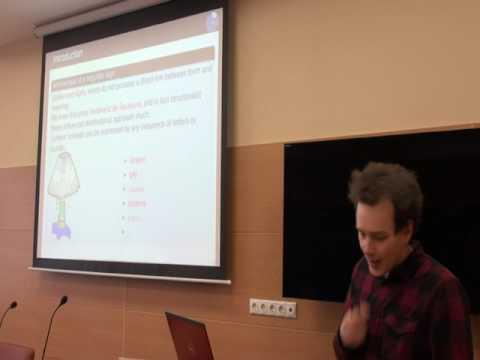

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('zoPutREr9UU', width=560, height=320)